In [2]:
# Import de bibliothèques

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import random
import os

import matplotlib.patches as patches
from PIL import Image
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from tensorflow import keras

In [32]:
# Le répertoire 'annotations' contient un fichier xml par photo donnant des indications comme la position des personnes

masque = []

file = random.choice(os.listdir('annotations/'))
with open("annotations/" + file, 'r') as fichier: 
    for ligne in fichier:
        if '<name>' in ligne:
            print(ligne.strip().replace('<name>','').replace('</name>',''))

with_mask
with_mask
without_mask
without_mask
mask_weared_incorrect
with_mask
with_mask
with_mask
without_mask
with_mask
without_mask


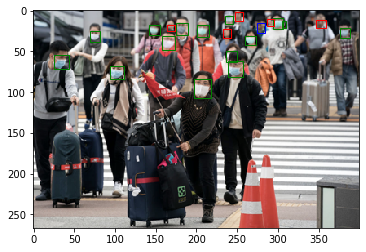

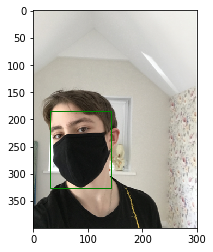

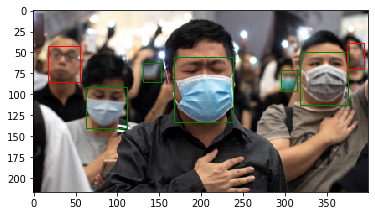

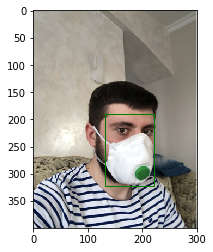

In [39]:
# Affichage des photos + cadres

def affiche_alea(nb_affiche):
    for _ in range(nb_affiche):
        x_min, x_max, y_min, y_max = [], [], [], []
        masque = []
        file = random.choice(os.listdir('images/'))

        with open("annotations/" + file.replace('.png','.xml'), 'r') as fichier: 
            for ligne in fichier: 
                if '<xmin>' in ligne:
                    add = ligne.strip().replace('<xmin>','').replace('</xmin>','')   
                    x_min.append(int(add))
                elif '<xmax>' in ligne:
                    add = ligne.strip().replace('<xmax>','').replace('</xmax>','')   
                    x_max.append(int(add))
                elif '<ymax>' in ligne:
                    add = ligne.strip().replace('<ymax>','').replace('</ymax>','')   
                    y_max.append(int(add))
                elif '<ymin>' in ligne:
                    add = ligne.strip().replace('<ymin>','').replace('</ymin>','')   
                    y_min.append(int(add))
                    
                elif '<name>' in ligne:
                    add = ligne.strip().replace('<name>','').replace('</name>','')
                    masque.append(add)

        im = np.array(Image.open('images/' + file), dtype=np.uint8)

        # Create figure and axes
        fig,ax = plt.subplots(1)

        # Display the image
        ax.imshow(im)

        for x_mini, x_maxi, y_mini, y_maxi, msq in zip(x_min, x_max, y_min, y_max, masque):
            if msq == 'with_mask':                
                # Create a Rectangle patch
                rect = patches.Rectangle((x_mini,y_mini),x_maxi-x_mini,y_maxi-y_mini,linewidth=1,
                                         edgecolor='g', facecolor='none')
            elif msq == 'without_mask':                
                # Create a Rectangle patch
                rect = patches.Rectangle((x_mini,y_mini),x_maxi-x_mini,y_maxi-y_mini,linewidth=1,
                                         edgecolor='r', facecolor='none')
            else:
                # Create a Rectangle patch
                rect = patches.Rectangle((x_mini,y_mini),x_maxi-x_mini,y_maxi-y_mini,linewidth=1,
                                         edgecolor='b', facecolor='none')
                
            # Add the patch to the Axes
            ax.add_patch(rect)

        plt.show()
        
affiche_alea(4)

In [40]:
# Avoir le nb max de personnes présentent sur une photo

liste_nb_pers = []

for file in os.listdir("annotations/"):
    with open("annotations/" + file, 'r') as fichier: 
        nb_pers = 0
        for ligne in fichier: 
            if '<name>' in ligne:
                nb_pers += 1
        liste_nb_pers.append(nb_pers)
    
print(max(liste_nb_pers))

115


In [41]:
# Création des jeux de données
# X : image du visage
# Y : port correct ou non du masque

X, y = [], []
ymax = 0

for file in os.listdir("annotations/"):
    with open("annotations/" + file, 'r') as fichier: 
        image = file.replace('.xml','.png')

        for ligne in fichier:
            if '<xmin>' in ligne:
                xmin = int(ligne.strip().replace('<xmin>','').replace('</xmin>',''))   
            elif '<xmax>' in ligne:
                xmax = int(ligne.strip().replace('<xmax>','').replace('</xmax>',''))
            elif '<ymax>' in ligne:
                ymax = int(ligne.strip().replace('<ymax>','').replace('</ymax>',''))   
            elif '<ymin>' in ligne:
                ymin = int(ligne.strip().replace('<ymin>','').replace('</ymin>',''))
                
            elif '<name>' in ligne:
                name = ligne.strip().replace('<name>','').replace('</name>','')
                
            if ymax != 0:              
                y.append(name)  
                                           
                X.append(
                    cv2.resize(
                        np.array(Image.open('images/' + image))[ymin:ymax+10,xmin:xmax], (100,100)
                    ) / 255.0
                )
                
                ymax = 0

print(len(y), len(X))

4072 4072


In [42]:
# Suppression de données manquantes

indice_a_garder = []
for i in range(len(X)):
    if X[i].shape == (100, 100, 4):
        indice_a_garder.append(i)

test = X
X = [test[i] for i in indice_a_garder]
test = y
y = [test[i] for i in indice_a_garder]
        
print(len(y), len(X))

4000 4000


In [43]:
# Vérification des dimensions

X = np.stack(X, axis=0)
y = np.array(y)
print(X.shape, y.shape)

(4000, 100, 100, 4) (4000,)


In [44]:
# Encodage des labels y
encoder = LabelEncoder()
y = encoder.fit_transform(y)
encoder.inverse_transform(np.array([0,1,2]))

array(['mask_weared_incorrect', 'with_mask', 'without_mask'], dtype='<U21')

In [45]:
# Création des jeux train, test, validation

(X_train_all, X_test, y_train_all, y_test) = train_test_split(X, y, test_size=0.1, random_state=42)

(X_train, X_valid, y_train, y_valid) = train_test_split(X_train_all, y_train_all, test_size=0.2, random_state=42)

y_train = y_train.reshape(-1,1)
y_valid = y_valid.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print(X_train.shape, y_train.shape,'\n',X_test.shape, y_test.shape,'\n',X_valid.shape, y_valid.shape)

(2880, 100, 100, 4) (2880, 1) 
 (400, 100, 100, 4) (400, 1) 
 (720, 100, 100, 4) (720, 1)


[1] --> ['with_mask']


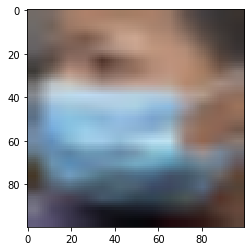

In [258]:
# Vérification des labels et photos du jeu d'entraînement

indice = 6
print(f'{y_train[indice]} --> {encoder.inverse_transform(y_train[indice])}')
im = X_train[indice]
fig,ax = plt.subplots(1)
ax.imshow(im)

In [296]:
# Création du modèle : CNN

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Conv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense

model = Sequential()
model.add(Conv2D(32, (3,3), padding="same", input_shape=(100,100,4)))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,3)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3,3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization())

model.add(Conv2D(64, (3,3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3,3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization())

model.add(Conv2D(128, (3,3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(3))
model.add(Activation("softmax"))

# compile the model
model.compile(loss="sparse_categorical_crossentropy", optimizer='adam', metrics=["acc"])

early_stopping = keras.callbacks.EarlyStopping(monitor='val_acc',
                                               patience=3, 
                                               restore_best_weights=True)

# train the model
history = model.fit(X_train, y_train,
                    validation_data=(X_valid, y_valid),
                    epochs=100, 
                    callbacks=[early_stopping])

Train on 2880 samples, validate on 720 samples
Epoch 1/100
2880/2880 [==============================] - 78s 27ms/sample - loss: 0.7263 - acc: 0.8361 - val_loss: 5.3105 - val_acc: 0.1736
Epoch 2/100
2880/2880 [==============================] - 60s 21ms/sample - loss: 0.3566 - acc: 0.9090 - val_loss: 3.0196 - val_acc: 0.4250
Epoch 3/100
2880/2880 [==============================] - 62s 22ms/sample - loss: 0.2682 - acc: 0.9278 - val_loss: 0.9756 - val_acc: 0.7181
Epoch 4/100
2880/2880 [==============================] - 68s 23ms/sample - loss: 0.2692 - acc: 0.9222 - val_loss: 0.6332 - val_acc: 0.8583
Epoch 5/100
2880/2880 [==============================] - 58s 20ms/sample - loss: 0.2167 - acc: 0.9389 - val_loss: 2.1439 - val_acc: 0.8208
Epoch 6/100
2880/2880 [==============================] - 55s 19ms/sample - loss: 0.2787 - acc: 0.9240 - val_loss: 0.4096 - val_acc: 0.9139
Epoch 7/100
2880/2880 [==============================] - 55s 19ms/sample - loss: 0.1754 - acc: 0.9483 - val_loss: 0.873

In [297]:
model.evaluate(X_test, y_test) # 92 % de bonnes réponses

400/400 [==============================] - 7s 17ms/sample - loss: 0.5222 - acc: 0.9200


[0.5221878822892905, 0.92]

[1] --> ['with_mask']


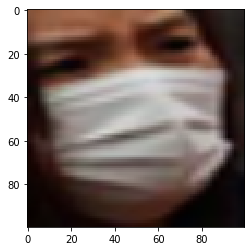

In [298]:
# Vérification du modèle

indice = 6
print(f'{y_test[indice]} --> {encoder.inverse_transform(y_train[indice])}')
im = X_test[indice]
fig,ax = plt.subplots(1)
ax.imshow(im)

[[32 73 48 48]]
32 73 48 48


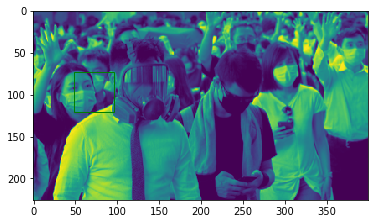

In [4]:
# Load the cascade
#face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Read the input image
img = cv2.imread('images/maksssksksss201.png')#14
# Convert into grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

fig,ax = plt.subplots(1)
ax.imshow(gray)

# Detect faces
faces = face_cascade.detectMultiScale(gray)#, 1.4, 4)
print(faces)

# Draw rectangle around the faces
for (x, y, w, h) in faces:
    print(x, y, w, h)
    rect = patches.Rectangle((w,y),w,h,linewidth=1,edgecolor='g', facecolor='none')
    ax.add_patch(rect)